# Linear Classifier

Linear Classifier Rule: Predicts class of given instance.
1. input each feature from an instance
2. multiply by feature-specific weight
3. summing up weighted features
4. check if total is + or -

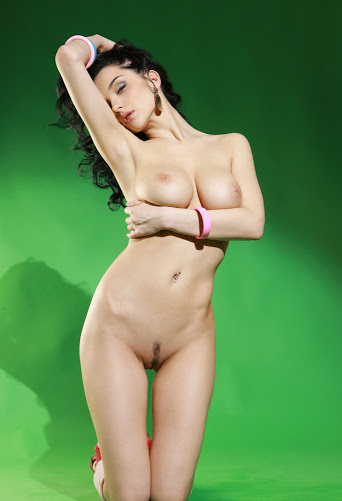

In [53]:
import numpy as np
from IPython.core.display import display
from keras_preprocessing import image

img = image.load_img("greenscreen.jpg")
arr = image.img_to_array(img)
arr = arr[:501,:]

# display(img)
display(image.array_to_img(arr,scale=False))

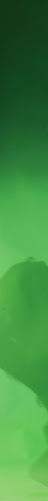

In [88]:
# get left background
tmp_left = arr[:,:48]
display(image.array_to_img(tmp_left,scale=False))
yesList1 = np.reshape(tmp_left,(-1,3))
#print(yesList1)

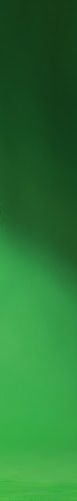

In [89]:
# get right background
tmp_right = arr[:,265:]
display(image.array_to_img(tmp_right,scale=False))
yesList2 = np.reshape(tmp_right,(-1,3))

In [91]:
yesList = np.concatenate((yesList1[:24000:2],yesList2[:24000:2]), axis=1)

In [92]:
#create an empty
x = np.array(3)
x.shape

()

In [93]:
x_list = np.reshape(x,(1,))
x_list.shape

(1,)

In [94]:
p = np.array((56,28,0))
p.shape

(3,)

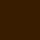

In [95]:
display(image.array_to_img(np.reshape(np.repeat(p,1600),(40,40,3),order='F'),scale=False))

In [96]:
tmp = arr[:,:360]
print(tmp.shape)

(501, 342, 3)


In [97]:
tmp = arr[:,:360]
yesList = np.reshape(tmp,(-1,3))
yesList.shape

(171342, 3)

In [98]:
# Foreground
tmp = arr[55:,130:145]
display(image.array_to_img(tmp,scale=False))

noList = np.reshape(tmp,(-1,3))

In [99]:
# build list of pixels for pos and neg examples
all_data = np.concatenate((yesList,noList))

#labels
labels = np.concatenate((np.ones(len(yesList)), np.zeros(len(noList))))

ex: r(-1) + g(1) + b(-1) + (0) >= 0 AND g >= r + b

loss function should score rules as having low loss if that rule agrees w/ labeled dataset

loss for entire data set = sum of losses for labeled instances

* <b>Instances:</b> r, g, b, label(0 or 1 indicating greenscreen or foreground)
* <b>Rule:</b> w<sub>r</sub>, w<sub>g</sub>, w<sub>b</sub>, c

If output of rule on the instance = label, then loss = 0
Otherwise, loss = 1

* loss grows when the rules don't fit the data

sigma(r wr + g wg + b wb + c) - label


* squaring it, as below, leaves 0 and 1 alone, and turns a -1 into a 1
(sigma(r wr + g wg + b wb + c) - label)<sup>2</sup> - 1

In [100]:
# add an additional column to the data corresponding to the offset parameter.
all_data = np.concatenate((all_data, np.ones((len(all_data),1))),1)

In [101]:
# compute the loss of the rule specified by weights with respect to the all_data labeled with "labels"
def loss(w, all_data, labels):
    # compute a weighted sum for each instance
    h = np.matmul(all_data, w)
    # transform the sum using the sigmoid function
    y = 1/(1+np.exp(-h))
    # take the diff between the labels and the output of the sigmoid squared then sum up over all instances to get the total loss
    loss = np.sum((labels - y)**2)

    return loss

In [102]:
# repeat 10 times
for i in range(10):
    # pick a random vector of weights with values between -1 and 1
    w = np.random.random(4)*2-1
    print(w, loss(w, all_data, labels))

[ 0.199037    0.84789012 -0.65520697 -0.08126117] 6696.587099191856
[ 0.07941548 -0.77675996 -0.60035094  0.74208326] 171272.44362443662
[-0.48844435 -0.47648119 -0.20163182  0.42109295] 171318.3567538179
[-0.95220075  0.17690727 -0.61453282 -0.06035232] 171268.8784293345
[-0.02819956 -0.14222375 -0.34163435  0.40304673] 171168.4901889503
[-0.84181064  0.00685362  0.12574144  0.76658882] 171200.27624989476
[-0.74537973  0.3294497  -0.05101127 -0.09794112] 81806.24848508895
[ 0.94596698  0.89363676 -0.4087408  -0.67642289] 6689.025629124655
[-0.79323467  0.81849609 -0.3374745   0.87731227] 55111.09834368593
[ 0.73072925 -0.33388876 -0.33041559 -0.22000847] 121927.50761252003


Gradient Descent: delta rule

DELTA w<sub>i</sub> = a (y-l) gprime(s) x<sub>i</sub>

ie:
* <b>DELTA w<sub>i</sub> :</b> change in weight from i to j for input x
* <b>a :</b> learning rate
* <b>(y-l) :</b> diff between output and target
* <b>gprime(s) :</b> derivative of sigmoid function for the sum
* <b>x<sub>i</sub> :</b> activation of unit i

DELTA w<sub>i</sub> = SIGMA//(x,y) [ a (y-l) gprime(s) x<sub>i</sub>]

In [103]:
# Gradient Descent / delta rule

def fit(w, all_data, labels):
    alpha = 0.1
    done = False
    while not done:
        if np.random.random() < 0.01: print(w, alpha, loss(w,all_data,labels))
        h = np.matmul(all_data,w)
        y = 1/(1+np.exp(-h))
        delta_w = np.add.reduce(np.reshape( (labels-y) * np.exp(-h) * y**2, (len(y), 1) ) * all_data)
        current_loss = loss(w,all_data,labels)
        alpha *= 2
        neww = w + alpha * delta_w

        # if we took too big of a step, half alpha, and try again.
        while loss(neww, all_data, labels) >= current_loss and not done:
            alpha /= 2
            if alpha * max(abs(delta_w)) < 0.0001:
                done = True
                print(alpha,delta_w)
            else: neww = w + alpha * delta_w
        if not done: w = neww
    return w

In [104]:
fit([0.789,0.147,-0.543,-0.249],all_data,labels)

0.4 [-6.80400081e-07 -1.66126965e-24 -4.59130750e-20 -2.26800027e-07]


array([ 4.7036751 , 54.26399927, 22.01625731,  1.18816958])

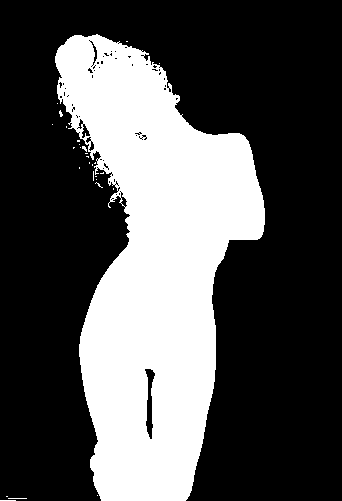

In [105]:
flat = np.reshape(arr, (-1, 3))
flat = np.concatenate( (flat, np.ones((len(flat),1)) ), 1)
out = np.matmul(flat, w) > 0.0
out = np.reshape(out, (-1, 1))
newarr = np.reshape(np.concatenate((out, out, out), 1), arr.shape)
display(image.array_to_img(newarr))